In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.fft

os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen
from GWGen.WFGenerator import *
import superrad

ulb = superrad.ultralight_boson.UltralightBoson(spin=1,model="relativistic")

In [3]:
# set initial parameters
M = 6e7
m = 1e1
mu = 5.1e-19
e0 = 0.1
p0 = GetInitialP(M,e0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


a=0.8 #SMBH Spin
Y0=1. #Initial Inclincation
qS=np.pi/4 #Sky Location Polar Angle in solar system barycenter coordinate system
phiS=0. #Sky Location Azimuthal Angle in solar system barycenter coordinate system
qK=1e-6 #Initial BH Spin Polar Angle in solar system barycenter coordinate system
phiK=0. #Initial BH Spin Azimuthal Angle in solar system barycenter coordinate system
dist=1. #Distance to source (Mpc)
mich=False #assume LISA long baseline response approximation

T=5.8 #LISA data run is 5 years. We set the max time to be longer because the proca cloud extends the inspiral time
dt=15 #time resolution in seconds

alphaval = alphavalue(M,mu)
print(r"alpha = {0}".format(alphaval))
print("initial p = {0}".format(p0))


use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
insp_kwargs = {
    "npoints": 110,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "dense_output":True
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}


alpha = 0.22898402468411
initial p = 4.83


# With Proca

In [4]:
ProcaInspiralKwargs = insp_kwargs.copy()
ProcaSumKwargs = sum_kwargs.copy()
withprocagen = EMRIWithProcaWaveform(inspiral_kwargs=ProcaInspiralKwargs,sum_kwargs=ProcaSumKwargs)
withproca = withprocagen(M,m,mu,a,p0,e0,Y0,T=T,qS=qS,phiS=phiS,qK=qK,phiK=phiK,dist=dist,mich=mich, UltralightBoson=ulb)

/mnt/Data_Volume/Documents/software/Anaconda/envs/few_env/lib/python3.7/site-packages/few/summation/aakwave.py:228: UserWarning: Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6.
  "Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6."


# Without Proca

In [5]:
WithoutProcaInspiralKwargs = insp_kwargs.copy()
WithoutProcaSumKwargs=sum_kwargs.copy()
withoutprocagen = EMRIWaveform(inspiral_kwargs=WithoutProcaInspiralKwargs, sum_kwargs=WithoutProcaSumKwargs, use_gpu=False)
withoutproca = withoutprocagen(M, m, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

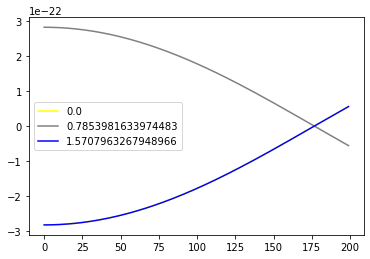

In [6]:
phi01 = 0.
phi02 = np.pi/4
phi03 = np.pi/2
withoutproca1 = withoutprocagen(M, m, a, p0, 1e-6, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=phi01, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=0.01)
withoutproca2 = withoutprocagen(M, m, a, p0, 1e-6, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=phi02, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=0.01)
withoutproca3 = withoutprocagen(M, m, a, p0, 1e-6, Y0, qS, phiS,qK, phiK, dist,Phi_phi0=phi03, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=0.01)
plt.plot(withoutproca1.real[0:200], label=str(phi01),color='yellow')
plt.plot(withoutproca2.real[0:200], label=str(phi02),color='gray')
plt.plot(withoutproca3.real[0:200], label=str(phi03),color='blue')
plt.legend()

# Plots

ValueError: operands could not be broadcast together with shapes (167,) (165,) 

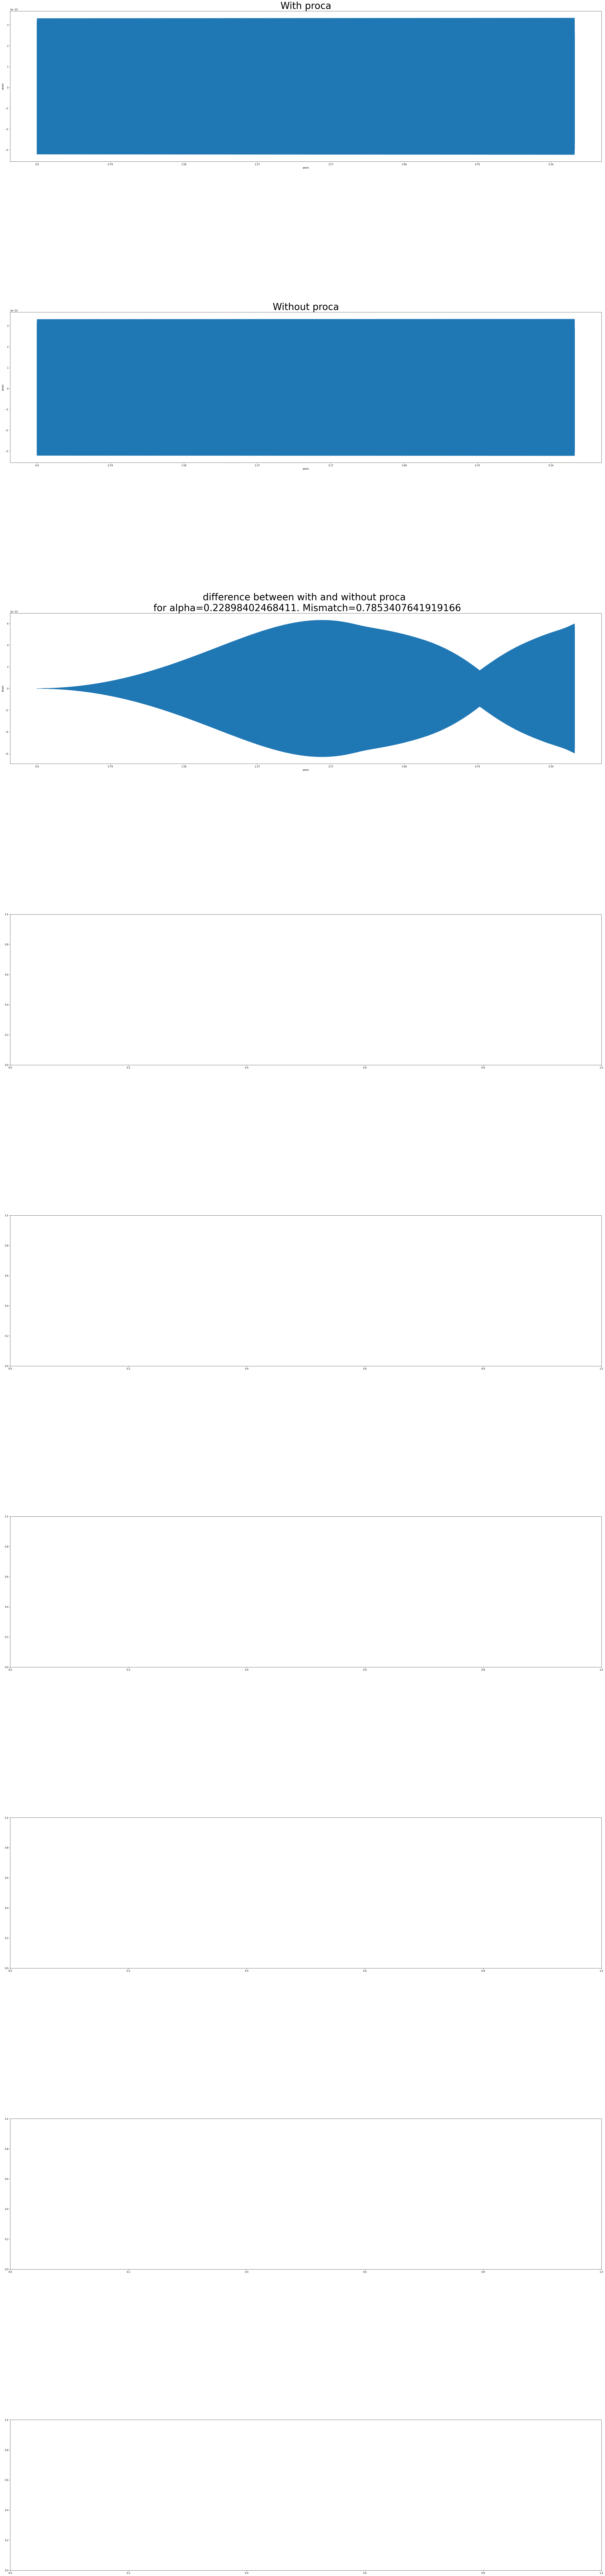

In [7]:
titlefontsize=40
legendsize=16;
if use_gpu:
    withoutproca = withoutproca.get()
    withproca=withproca.get()
mismatch = get_mismatch(withoutproca, withproca)

tp = np.arange(len(withproca)) * dt;
twp = np.arange(len(withoutproca)) * dt

fig,ax = plt.subplots(9,1, figsize=(45,200))
plt.subplots_adjust(hspace=1, wspace=0.5)
ax[0].plot(tp, withproca.real)
ax[0].set_title("With proca", fontsize=titlefontsize)
ticks = ax[0].get_xticks()[1:-1];
newlabs = np.array([int(i)/100 for i in (ticks*100/(60*60*24*365))]);
ax[0].set_xticks(ticks, newlabs);
ax[0].set_xlabel("years");
ax[0].set_ylabel("strain");

ax[1].plot(twp, withoutproca.real)
ax[1].set_title("Without proca", fontsize=titlefontsize)
ticks = ax[1].get_xticks()[1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
ax[1].set_xticks(ticks, newlabs);
ax[1].set_xlabel("years");
ax[1].set_ylabel("strain");

minwave = min([len(withproca), len(withoutproca)])
dom =tp[0:minwave-1]
ax[2].plot(dom, (withproca.real[0:minwave-1]-withoutproca.real[0:minwave-1]));
ax[2].set_title("difference between with and without proca \n for alpha={0}. Mismatch={1}".format(alphaval,mismatch), fontdict={"fontsize":9}, fontsize=titlefontsize);
ticks = ax[2].get_xticks()[1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
ax[2].set_xticks(ticks, newlabs);
ax[2].set_xlabel("years");
ax[2].set_ylabel("strain");


minsize = min([len(tp), len(twp)])
dom = withprocagen.Trajectory["t"]
#N_orbits = phase/(4*pi)
Difference = (withprocagen.Trajectory["Phi_phi"] - withoutprocagen.Trajectory["Phi_phi"])/(4*np.pi)
ax[3].plot(withprocagen.Trajectory["t"], Difference, label="withproca")
ax[3].set_title(r"$\Delta N$ number of GW cycles", fontsize=titlefontsize)
ax[3].legend(prop={'size':legendsize})
ticks = ax[3].get_xticks()[1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
ax[3].set_xticks(ticks, newlabs);
ax[3].set_xlabel("years");
ax[3].set_ylabel("phase");


ax[4].plot(withprocagen.Trajectory["t"], withprocagen.Trajectory["p"], label="with proca")
ax[4].set_title(" semi-latus rectum evolution", fontsize=titlefontsize)
ax[4].legend(prop={'size':legendsize})
ticks = ax[4].get_xticks()[1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
ax[4].set_xticks(ticks, newlabs);
ax[4].set_xlabel("years");
ax[4].set_ylabel("p");

ax[5].plot(withoutprocagen.Trajectory["t"], withoutprocagen.Trajectory["p"], label="without proca")
ax[5].set_title(" semi-latus rectum evolution", fontsize=titlefontsize)
ax[5].legend(prop={'size':legendsize})
ticks = ax[5].get_xticks()[1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
ax[5].set_xticks(ticks, newlabs);
ax[5].set_xlabel("years");
ax[5].set_ylabel("p");


minsize = min([len(tp), len(twp)])
dom = tp[0:minsize-1]
ax[6].plot(withprocagen.Trajectory["t"], withprocagen.Trajectory["p"], label="withproca")
ax[6].plot(withoutprocagen.Trajectory["t"], withoutprocagen.Trajectory["p"], label="withoutproca")
ax[6].set_title(" semi-latus rectum evolution", fontsize=titlefontsize)
ax[6].legend(prop={'size':legendsize})
ticks = ax[6].get_xticks()[1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
ax[6].set_xticks(ticks, newlabs);
ax[6].set_xlabel("years");
ax[6].set_ylabel("p");


minsize = min([len(tp), len(twp)])
dom = tp[0:minsize-1]
ax[7].plot(withprocagen.Trajectory["p"], withprocagen.Trajectory["e"], label="withproca")
ax[7].plot(withoutprocagen.Trajectory["p"], withoutprocagen.Trajectory["e"], label="withoutproca")
ax[7].set_title(" configuration space trajectory", fontsize=titlefontsize)
ax[7].legend(prop={'size':legendsize})
ax[7].set_xlabel("e");
ax[7].set_ylabel("p");


minsize = min([len(tp), len(twp)])
dom = tp[0:minsize-1]
ax[8].plot(withprocagen.Trajectory["t"], withprocagen.Trajectory["e"], label="withproca")
ax[8].plot(withoutprocagen.Trajectory["t"], withoutprocagen.Trajectory["e"], label="withoutproca")
ax[8].set_title(" eccentricity evolution", fontsize=titlefontsize)
ax[8].legend(prop={'size':legendsize})
ticks = ax[8].get_xticks()[1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
ax[8].set_xticks(ticks, newlabs);
ax[8].set_xlabel("years");
ax[8].set_ylabel("e");

plt.show()
